In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 32.8 MB/s eta 0:00:00


In [3]:
import timm
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

# Define the data transforms

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transforms = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),
])

# Create a custom dataset class
from torchvision.transforms import ToTensor
class CustomDataset(Dataset):
    def __init__(self, image_file, label_file, transform=None):
        self.images = np.load(image_file)
        # self.images = (self.images - np.mean(self.images)) / np.std(self.images)
        self.labels = np.load(label_file)
        self.transform = transform
        # self.max_value = np.amax(self.images)
        # self.min_value = np.amin(self.images)

    def __len__(self):
        return len(self.images)


    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Apply the transformation
        if self.transform:
          # Apply random cropping to both the image and the mask
          seed = np.random.randint(2147483647)
          random.seed(seed)
          image = Image.fromarray(image)
          image = self.transform(image)

          random.seed(seed)
          label = Image.fromarray(label)
          label = self.transform(label)

          # Convert images and masks back to NumPy arrays
          image = np.array(label)
          label = np.array(label)        

        # # Convert image and label to torch tensors
        # image = (image - self.min_value) / (self.max_value - self.min_value)
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).long()

        return image, label

# Load your image and mask paths

image_paths = '/content/drive/MyDrive/EECS545FinalProject/CorrectData/train_input.npy'
mask_paths = '/content/drive/MyDrive/EECS545FinalProject/CorrectData/train_labels.npy'
image_paths1 = '/content/drive/MyDrive/EECS545FinalProject/CorrectData/test_input.npy'
mask_paths1 = '/content/drive/MyDrive/EECS545FinalProject/CorrectData/test_labels.npy'

In [4]:
# Split the dataset into training and testing sets
train_dataset = CustomDataset(image_paths, mask_paths, transform=None)
test_dataset = CustomDataset(image_paths1, mask_paths1, transform=None)

# Set up the DataLoader
bs = 42
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=0)


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CombinedFocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, gamma=2, beta=0.3, eps=1e-7, focal_weight=0.5):
        super(CombinedFocalTverskyLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.beta = beta
        self.eps = eps
        self.focal_weight = focal_weight
        self.tversky_weight = 1 - focal_weight

    def focal_loss(self, y_pred, y_true):
        bce = F.binary_cross_entropy_with_logits(y_pred, y_true, reduction='none')
        p_t = torch.exp(-bce)
        focal_loss = self.alpha * (1 - p_t)**self.gamma * bce
        return focal_loss.mean()

    def tversky_loss(self, y_pred, y_true):
        y_pred = torch.sigmoid(y_pred)
        y_pred = y_pred.reshape(-1)
        y_true = y_true.reshape(-1)
        tp = (y_pred * y_true).sum()
        fp = ((1 - y_true) * y_pred).sum()
        fn = (y_true * (1 - y_pred)).sum()
        tversky_index = tp / (tp + self.alpha * fp + self.beta * fn)
        return 1 - tversky_index

    def forward(self, y_pred, y_true):
        focal = self.focal_loss(y_pred, y_true)
        tversky = self.tversky_loss(y_pred, y_true)
        combined_loss = self.focal_weight * focal + self.tversky_weight * tversky
        return combined_loss
        
criterion = CombinedFocalTverskyLoss(alpha=0.75, gamma=4, beta=0.2, focal_weight=0.33)

In [8]:
# New ViT Network Architecture
import torch
import torch.nn as nn
from torchvision import models
import timm
import torch.nn.functional as F

torch.cuda.empty_cache()

class ViTModel(nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()

        # Vision Transformer
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0, drop_rate=0.1)

        # Decoder layers
        self.decoder4 = nn.Sequential(
            nn.ConvTranspose2d(768, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, num_classes, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
        
        self.batch_norm = nn.BatchNorm2d(num_classes)

    def forward(self, x):
        x_resized = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        vit_features = self.vit(x_resized)

        vit_features = vit_features.unsqueeze(-1).unsqueeze(-1)
        vit_features = F.interpolate(vit_features, size=(x.shape[2]//16, x.shape[3]//16), mode='nearest')

        d4 = self.decoder4(vit_features)
        d4_adapt = F.adaptive_avg_pool2d(d4, (x.shape[2]//8, x.shape[3]//8))
        d3 = self.decoder3(d4_adapt)
        d3_adapt = F.adaptive_avg_pool2d(d3, (x.shape[2]//4, x.shape[3]//4))
        d2 = self.decoder2(d3_adapt)
        d2_adapt = F.adaptive_avg_pool2d(d2, (x.shape[2]//2, x.shape[3]//2))
        d1 = self.decoder1(d2_adapt)

        output = F.interpolate(d1, size=x.shape[2:], mode='bilinear', align_corners=False)
        out = self.batch_norm(output)
        return out

num_classes = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTModel(num_classes).to(device)


In [9]:
# Test input dimension
input_tensor = torch.randn(1, 3, 310, 360).to(device)

# Forward pass through the model
output = model(input_tensor)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 3, 310, 360])


In [10]:
# # Freeze model pretrained weight
for param in model.vit.parameters():
  param.requires_grad = False

In [11]:
model.load_state_dict(torch.load('/content/drive/MyDrive/EECS545FinalProject/CorrectData/TrainedModelWeights/PURE_VIT.pt'))

<All keys matched successfully>

In [12]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.0000007, betas=(0.79, 0.89))

# Train the model
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        masks = masks.float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f'Epoch: {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}')

print("Training finished.")

Epoch: 1/5, Train Loss: 0.6575
Epoch: 2/5, Train Loss: 0.6574
Epoch: 3/5, Train Loss: 0.6575
Epoch: 4/5, Train Loss: 0.6575
Epoch: 5/5, Train Loss: 0.6574
Training finished.


In [13]:
torch.save(model.state_dict(), '/content/drive/MyDrive/EECS545FinalProject/CorrectData/TrainedModelWeights/PURE_VIT.pt')

In [14]:
# Load test dataset

test_data_path = '/content/drive/MyDrive/EECS545FinalProject/CorrectData/test_input.npy'
test_labels_path = '/content/drive/MyDrive/EECS545FinalProject/CorrectData/test_labels.npy'
val_input_path = '/content/drive/MyDrive/EECS545FinalProject/CorrectData/val_input.npy'
val_labels_path = '/content/drive/MyDrive/EECS545FinalProject/CorrectData/val_labels.npy'

# Create a CustomDataset for test data

test_dataset = CustomDataset(test_data_path, test_labels_path, transform=None)


In [15]:
# Overall Test error
batch_size = 126

# Create a DataLoader for test data
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
num_classes = 3

In [16]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix

model.eval()

running_auc_roc = 0
running_accuracy = 0
running_f1_score = 0
running_sensitivity = 0
running_specificity = 0

# Test loop
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        binary_preds = (outputs > 0.5).float()

        targets = targets.view(-1, num_classes).cpu().numpy()
        binary_preds = binary_preds.view(-1, num_classes).cpu().numpy()

        for i in range(num_classes):
            running_auc_roc += roc_auc_score(targets[:, i], binary_preds[:, i])
            tn, fp, fn, tp = confusion_matrix(targets[:, i], binary_preds[:, i]).ravel()
            running_accuracy += (tp + tn) / (tp + tn + fp + fn)
            running_f1_score += 2 * tp / (2 * tp + fp + fn)
            running_sensitivity += tp / (tp + fn)
            running_specificity += tn / (tn + fp)

        progress = (batch_idx + 1) / len(test_loader) * 100
        print(f"Progress: {progress:.2f}%")

average_auc_roc = running_auc_roc / (len(test_loader) * num_classes)
average_accuracy = running_accuracy / (len(test_loader) * num_classes)
average_f1_score = running_f1_score / (len(test_loader) * num_classes)
average_sensitivity = running_sensitivity / (len(test_loader) * num_classes)
average_specificity = running_specificity / (len(test_loader) * num_classes)

print(f"Overall Metrics:")
print(f"  Average AUC-ROC: {average_auc_roc}")
print(f"  Average Accuracy: {average_accuracy}")
print(f"  Average F1-score: {average_f1_score}")
print(f"  Average Sensitivity (Recall): {average_sensitivity}")
print(f"  Average Specificity: {average_specificity}")

Progress: 7.14%
Progress: 14.29%
Progress: 21.43%
Progress: 28.57%
Progress: 35.71%
Progress: 42.86%
Progress: 50.00%
Progress: 57.14%
Progress: 64.29%
Progress: 71.43%
Progress: 78.57%
Progress: 85.71%
Progress: 92.86%
Progress: 100.00%
Overall Metrics:
  Average AUC-ROC: 0.5002353946882027
  Average Accuracy: 0.9905107509949422
  Average F1-score: 0.0010843717831768376
  Average Sensitivity (Recall): 0.0005814220845995359
  Average Specificity: 0.9998893672918057


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLossLogits(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLossLogits, self).__init__()
        self.smooth = smooth

    def forward(self, logits, target):
        pred = torch.sigmoid(logits)
        pred = pred.view(-1)
        target = target.view(-1)

        intersection = (pred * target).sum()
        cardinalities_sum = pred.sum() + target.sum()

        loss = 1 - (2 * intersection + self.smooth) / (cardinalities_sum + self.smooth)
        return loss

In [18]:
criterion = DiceLossLogits()

In [19]:
# Switch the model to evaluation mode
model.eval()

test_error = 0
total_samples = 0

# Iterate through the test dataset
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float()  # Convert the target tensor to float
        
        # Forward pass
        outputs = model(inputs)
        # ['out']
        
        # Calculate the loss
        loss = criterion(outputs, labels)
        
        # Update test error and total samples
        test_error += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

# Calculate the average test dice error
avg_test_error = test_error / total_samples
print("Average Test Error: {:.4f}".format(avg_test_error))

Average Test Error: 0.9686


In [20]:
criterion = nn.BCEWithLogitsLoss()

In [21]:
# Switch the model to evaluation mode
model.eval()

test_error = 0
total_samples = 0

# Iterate through the test dataset
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float()  # Convert the target tensor to float
        
        # Forward pass
        outputs = model(inputs)
        # ['out']
        
        # Calculate the loss
        loss = criterion(outputs, labels)
        
        # Update test error and total samples
        test_error += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

# Calculate the average BCE error
avg_test_error = test_error / total_samples
print("Average Test Error: {:.4f}".format(avg_test_error))

Average Test Error: 0.2078


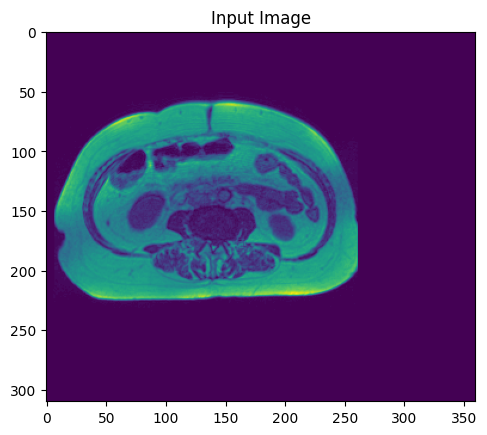

[0.]
[0 1]


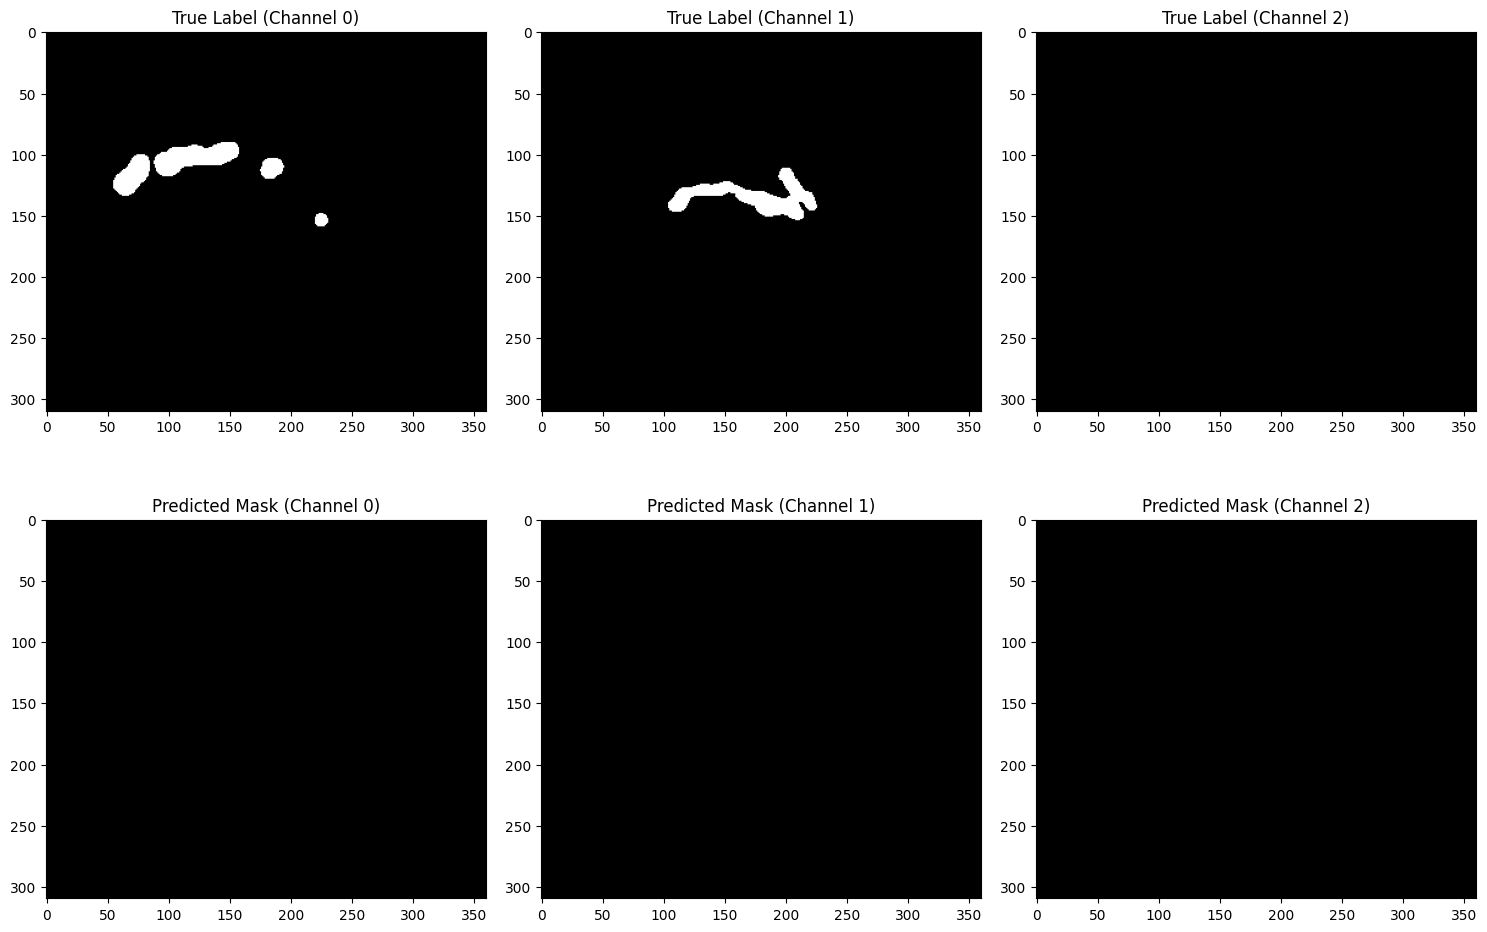

In [22]:
# Visualize a single test sample

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

model.eval()

test_sample = next(iter(test_loader))

# test_sample = next(iter(test_loader))

inputs, true_labels = test_sample

inputs, true_labels = inputs.to(device), true_labels.to(device)

with torch.no_grad():
    outputs = model(inputs)
    # outputs = model(inputs)['out']

probs = torch.sigmoid(outputs)
predicted_labels = (probs > 0.5).float()


import matplotlib.pyplot as plt

input_image = inputs.cpu().squeeze().numpy()
plt.imshow(input_image[1,:,:])
plt.title("Input Image")
plt.show()

# Move the true_label and pred_mask back to the CPU and remove the batch dimension

true_label = true_labels.squeeze().cpu().numpy()
pred_mask = predicted_labels.squeeze().cpu().numpy()

print(np.unique(pred_mask))
print(np.unique(true_label))
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for i in range(3):
    ax[0, i].imshow(true_label[i,:,:], cmap='gray')
    ax[0, i].set_title(f"True Label (Channel {i})")
    
    ax[1, i].imshow(pred_mask[i,:,:], cmap='gray')
    ax[1, i].set_title(f"Predicted Mask (Channel {i})")

plt.tight_layout()
plt.show()